In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e10/sample_submission.csv
/kaggle/input/playground-series-s3e10/train.csv
/kaggle/input/playground-series-s3e10/test.csv
/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Libraries</div>


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import missingno as msno

import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression, Ridge
import optuna
import lightgbm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from scipy.optimize import differential_evolution

from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Read Data</div>


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv')
extra_data = pd.read_csv("/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e10/sample_submission.csv")
train = train.drop('id' ,axis=1)
test.drop('id' ,axis =1 ,inplace = True)

In [4]:
train.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Summary</div>


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Mean_Integrated       117564 non-null  float64
 1   SD                    117564 non-null  float64
 2   EK                    117564 non-null  float64
 3   Skewness              117564 non-null  float64
 4   Mean_DMSNR_Curve      117564 non-null  float64
 5   SD_DMSNR_Curve        117564 non-null  float64
 6   EK_DMSNR_Curve        117564 non-null  float64
 7   Skewness_DMSNR_Curve  117564 non-null  float64
 8   Class                 117564 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.1 MB


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Checking Null</div>


<AxesSubplot:>

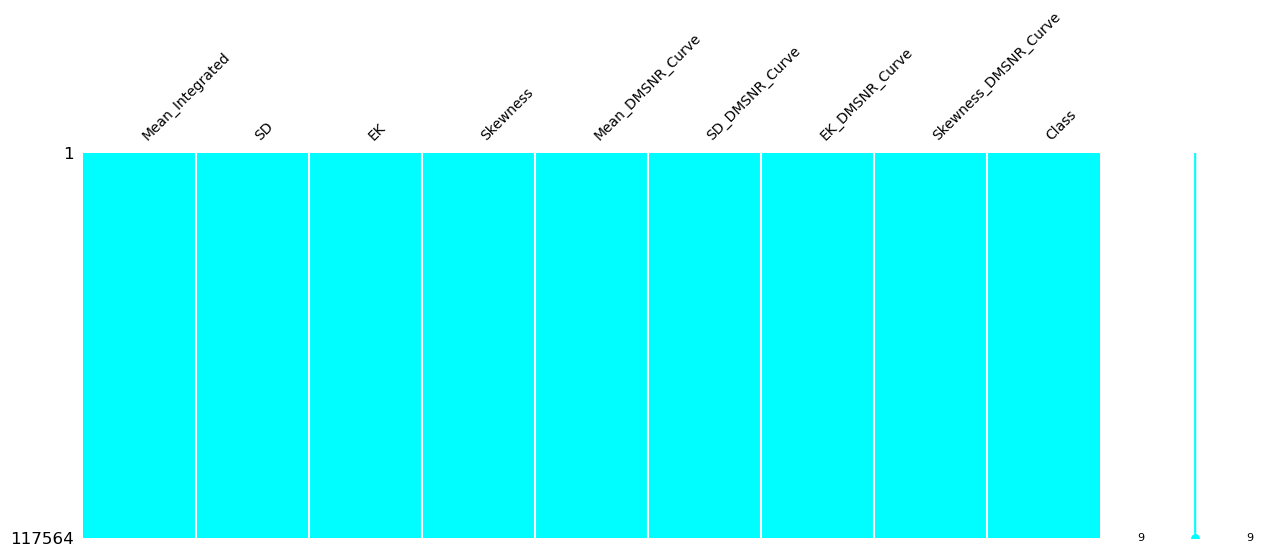

In [6]:
msno.matrix(train ,color=[0.003,0.996,1] ,figsize=(15,5) , width_ratios=(10,1),fontsize=10)

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Descriptive Statistics</div>


In [7]:
train.describe().T.style.background_gradient(cmap='cool')

,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,117564.000000,111.248300,24.906474,6.054688,104.546875,116.664062,126.296875,189.367188
SD,117564.000000,46.713535,6.102941,24.783273,43.443390,47.478932,50.862718,93.602933
EK,117564.000000,0.503498,1.127093,-1.730782,0.049761,0.186498,0.395620,7.879628
Skewness,117564.000000,1.886385,6.515466,-1.791886,-0.188956,0.091720,0.691613,65.385974
Mean_DMSNR_Curve,117564.000000,11.962921,26.719946,0.213211,2.090301,2.808528,4.122910,217.371238
SD_DMSNR_Curve,117564.000000,26.190678,20.041937,7.370432,14.955405,18.164924,24.732218,109.890785
EK_DMSNR_Curve,117564.000000,8.037488,3.840980,-2.597872,6.742911,8.442883,10.003237,34.539844
Skewness_DMSNR_Curve,117564.000000,93.881076,79.962110,-1.976976,49.409136,83.421375,122.093290,1191.000837
Class,117564.000000,0.093285,0.290833,0.000000,0.000000,0.000000,0.000000,1.000000


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Corrleation Matrix</div>


<AxesSubplot:>

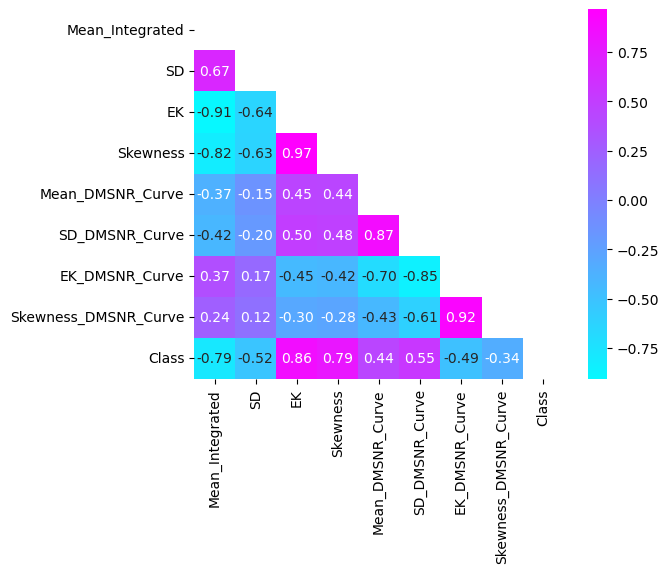

In [8]:
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr() , cmap='cool' ,annot=True ,square=True ,center=0 ,fmt='.2f' ,mask=mask)

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Plots</div>


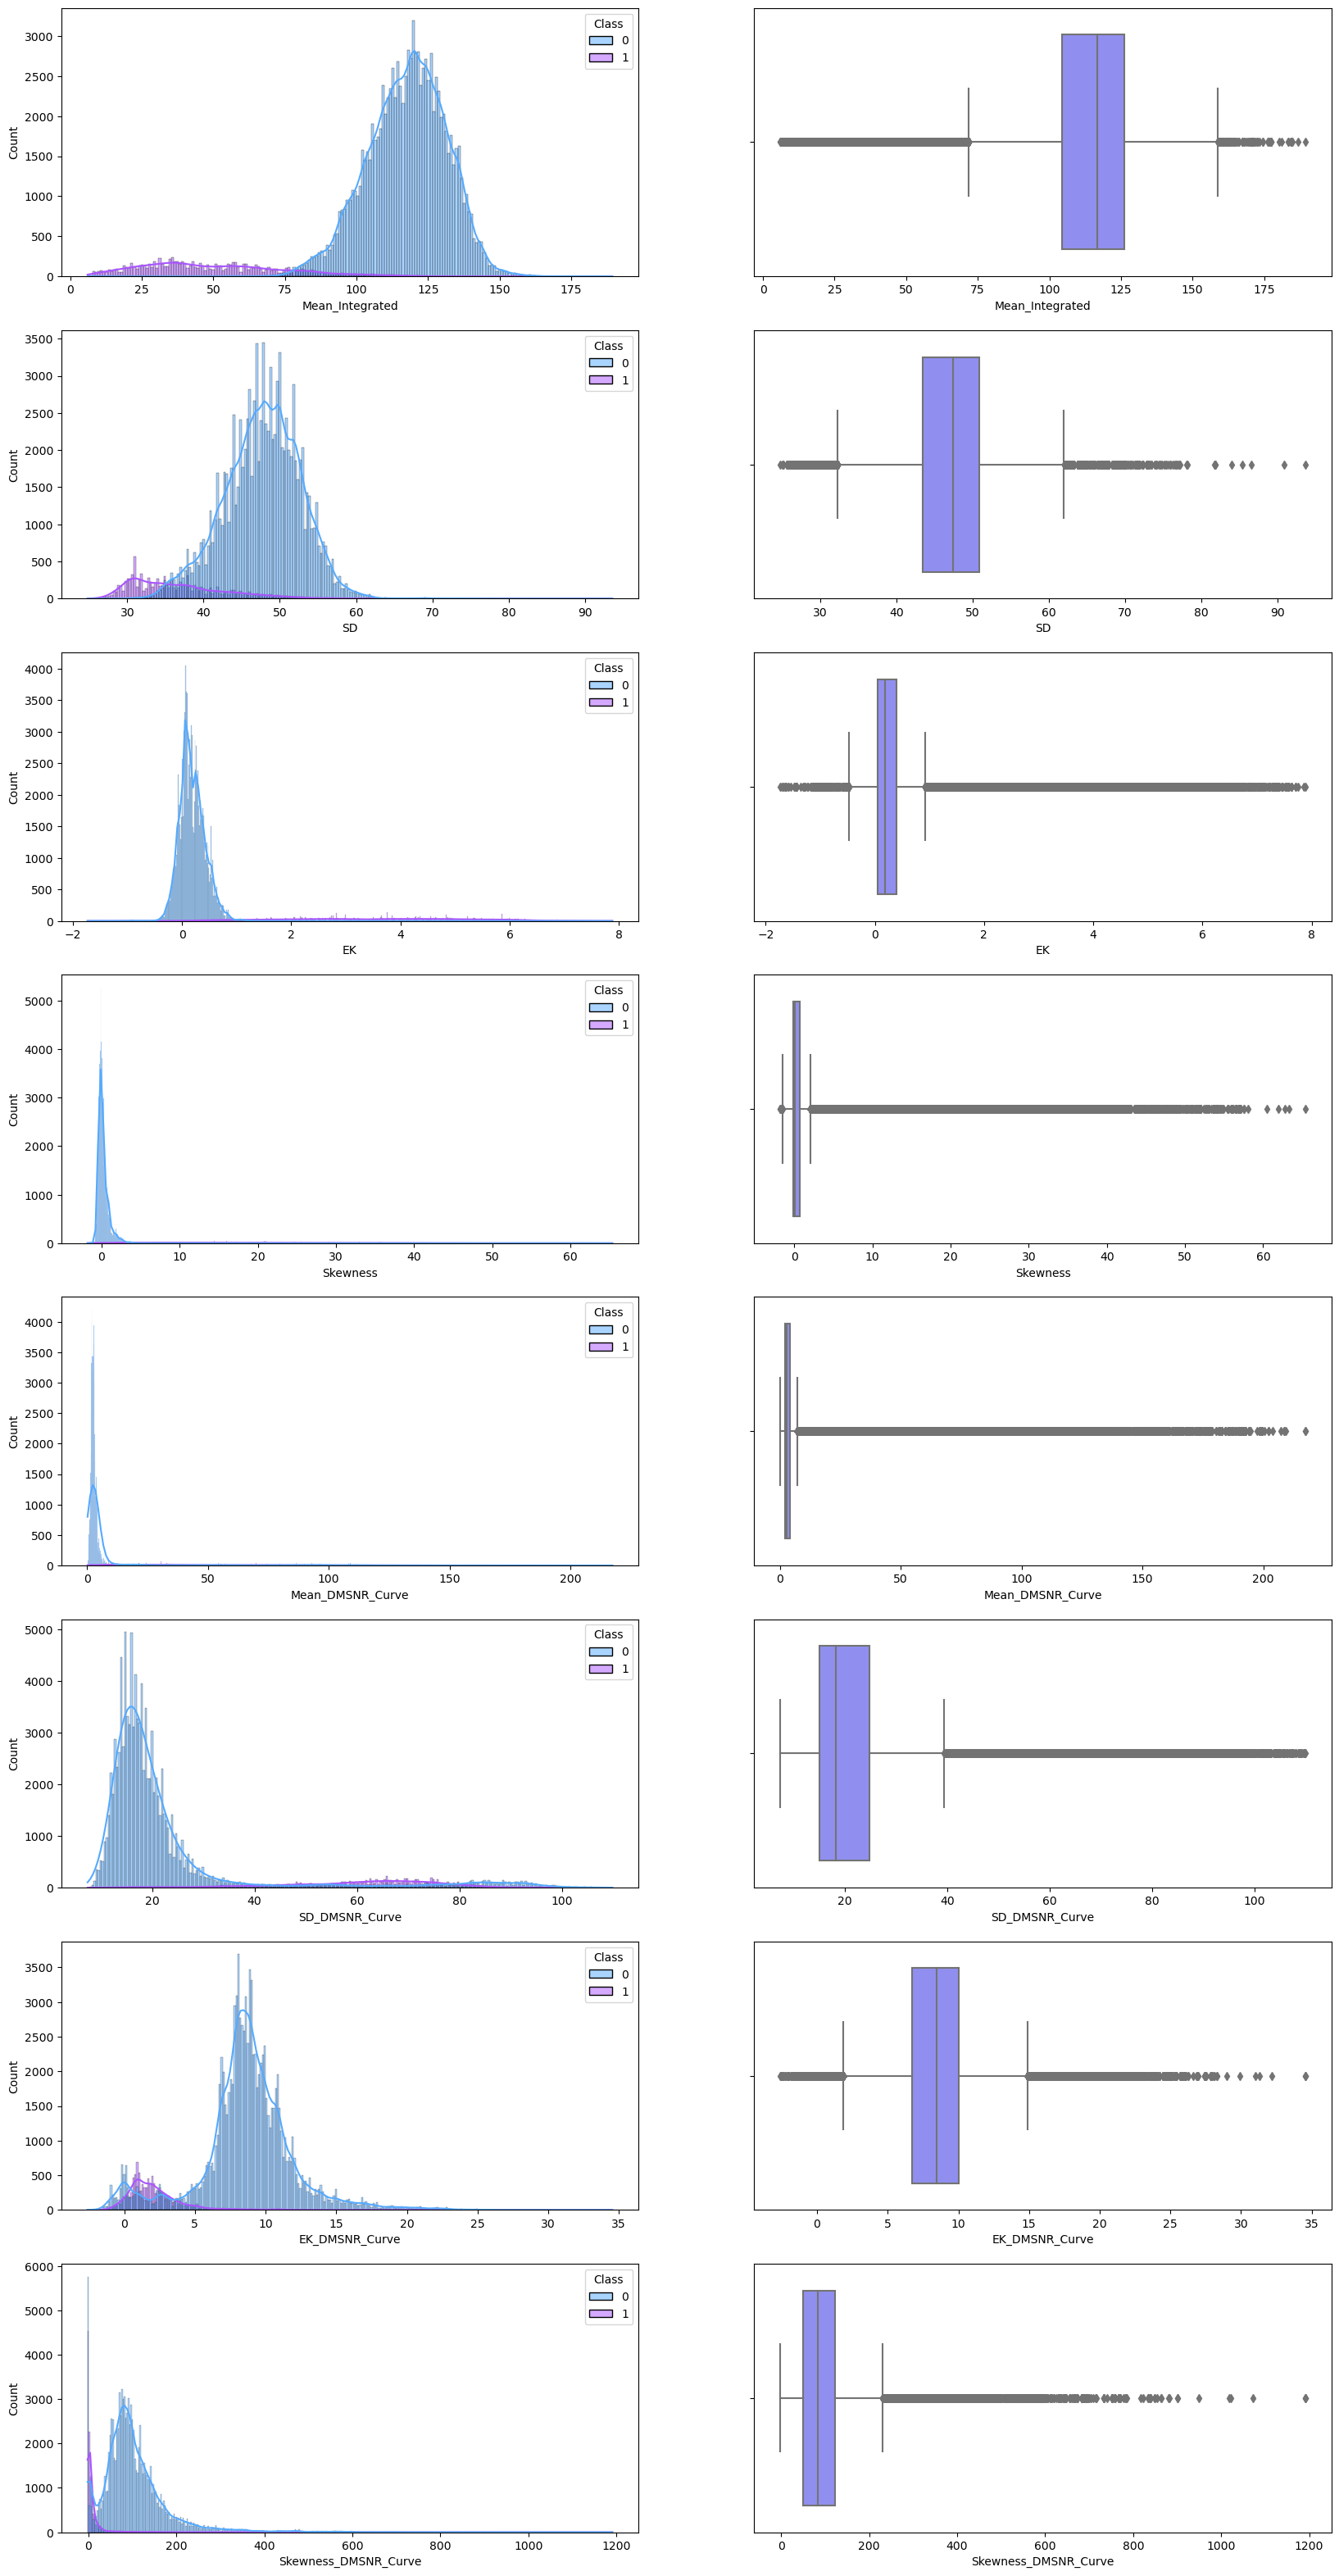

In [9]:

X = train.drop('Class',axis=1)
y = train['Class']

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,40))
for i in range(len(X.columns)):
    col = train.columns[i]
    sns.histplot(x=train[col], hue=y, palette="cool", kde=True, ax=axes[i][0])
    sns.boxplot(x=train[col] , ax=axes[i][1] ,palette="cool",hue=y )
    
plt.show()

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Outlier Percentage</div>


In [10]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        q1 = np.quantile(data[column], 0.25)
        q3 = np.quantile(data[column], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_percent = (outliers.shape[0] / data.shape[0]) * 100
        outlier_percents[column] = outlier_percent
        
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage').style.background_gradient(cmap='cool')


detect_outliers(train)

,Outlier_percentage
SD,3.196557
Skewness_DMSNR_Curve,4.808445
Mean_Integrated,7.767684
Class,9.328536
EK,9.400837
Skewness,11.221122
EK_DMSNR_Curve,13.550066
SD_DMSNR_Curve,15.876459
Mean_DMSNR_Curve,17.644857


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Skewness Check</div>


In [11]:
def skew(col):
    if ((col < 0.5) & (col > -0.5)):
        return "Normally Distributed"
    elif ((col<1) & (col > 0.5)):
        return "Positively skewed"
    elif (col<-0.5) & (col>-1 ):
        return "Negatively Skewed"
    elif (col < -1):
        return "Highly Negatively Skewed - Do Sqaure Root Transformation"
    elif (col>1):
        return "Highly Positively Skewed - Do Log Transform"
    

skew_data = pd.DataFrame(train.skew() , columns=['Skewness'])
skew_data['Remark'] = skew_data['Skewness'].apply(lambda x : skew(x))

In [12]:
skew_data.style.background_gradient(cmap='cool')

,Skewness,Remark
Mean_Integrated,-1.841348,Highly Negatively Skewed - Do Sqaure Root Transformation
SD,-0.523879,Negatively Skewed
EK,3.434997,Highly Positively Skewed - Do Log Transform
Skewness,4.397575,Highly Positively Skewed - Do Log Transform
Mean_DMSNR_Curve,3.424710,Highly Positively Skewed - Do Log Transform
SD_DMSNR_Curve,2.010345,Highly Positively Skewed - Do Log Transform
EK_DMSNR_Curve,-0.041686,Normally Distributed
Skewness_DMSNR_Curve,2.374033,Highly Positively Skewed - Do Log Transform
Class,2.796941,Highly Positively Skewed - Do Log Transform


<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Skewness Handle</div>


In [13]:
# Processing...

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Multicollinearity</div>


<AxesSubplot:>

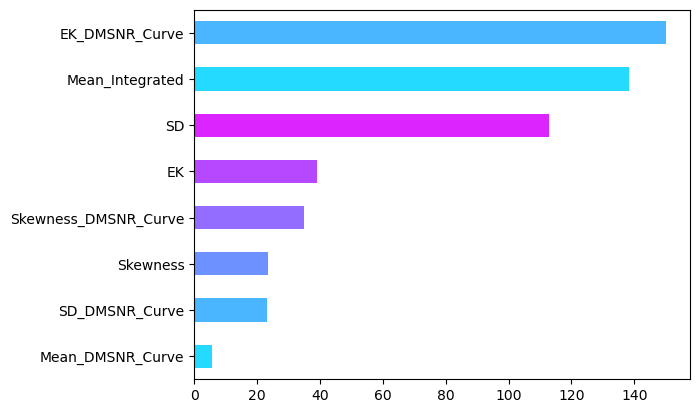

In [14]:
# Multicollinearity test
# VIF - (Variance Inflation Factor)
X = train.drop('Class' ,axis =1)
y = train['Class']
vif_list = []
for i in range(len(X.columns)):
    vif = variance_inflation_factor(X.to_numpy() , i)
    vif_list.append(vif)
    
series = pd.Series(vif_list , index = X.columns)
series.sort_values().plot(kind='barh' ,color = sns.color_palette("cool") )

# cool_colors = sns.color_palette("cool")

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Checking Class</div>


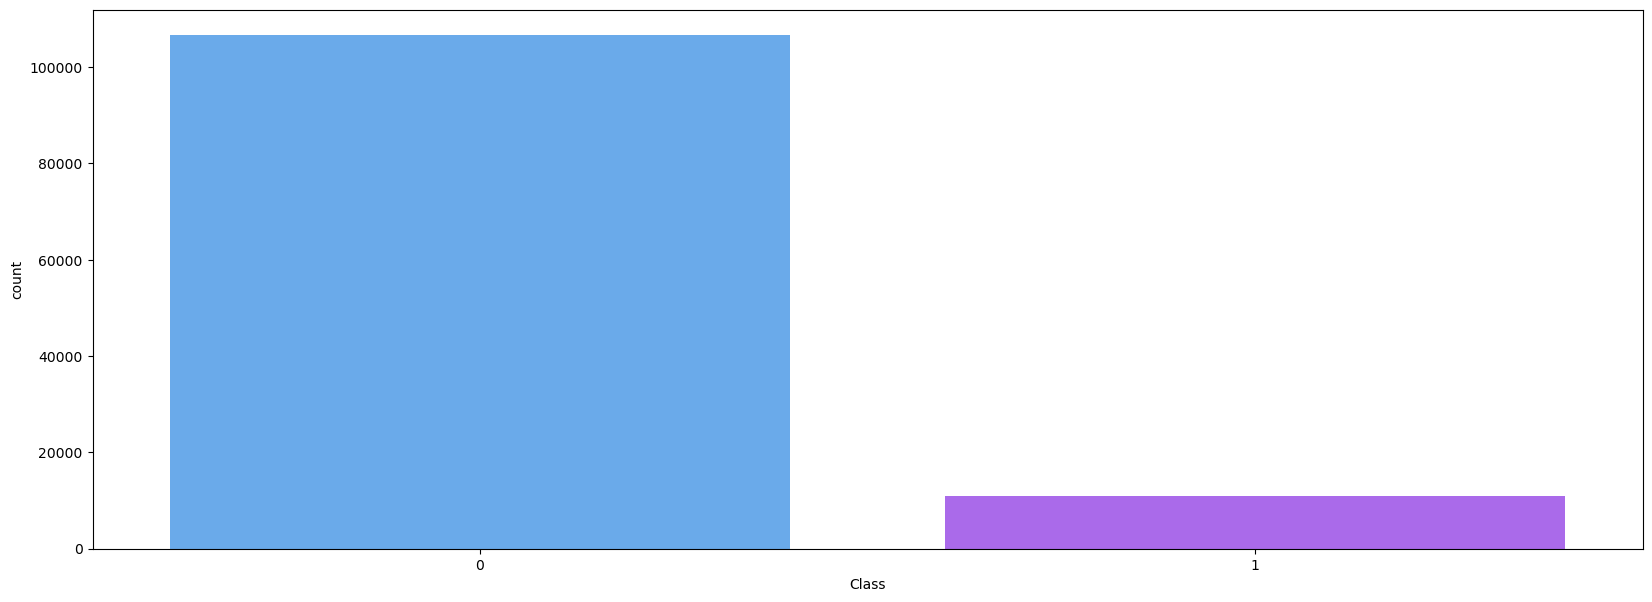

In [15]:
X = train.drop('Class',axis=1)
y = train.Class
plt.figure(figsize=(20,7))
sns.countplot(x="Class", data=train, palette="cool")
plt.show()

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Model Building</div>


In [16]:
train_targets = train["Class"]
extra_targets = extra_data["Class"]

train.drop("Class", axis=1, inplace=True)
extra_data.drop("Class", axis=1, inplace=True)

In [17]:
lgb_pbounds = {'num_leaves': (5, 50),
               'max_depth': (2, 10),
               'learning_rate': (0.01, 0.5),
               'min_child_weight': (1, 10),
               'colsample_bytree': (0.1, 1),
               'subsample': (0.1, 1)}

xgb_pbounds = {'max_depth': (2, 10),
               'learning_rate': (0.01, 0.5),
               'gamma': (0, 1),
               'min_child_weight': (1, 10),
               'max_delta_step': (0, 10),
               'subsample': (0.1, 1),
               'colsample_bytree': (0.1, 1)}

cat_pbounds = {'learning_rate': (0.01, 0.3),
               'max_depth': (3, 7),
               'n_estimators': (50, 200),
               'l2_leaf_reg': (1, 10)}
coeff_pbounds = {"a":(0,1),
                "b":(0,1),
                "c":(0,1)}

In [18]:
test_preds = np.zeros(len(test))
cv = 0
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train, train_targets)):
    print()
    print('\033[1m\033[10m\033[38;2;255;0;255m' + "Fold is:" ,fold , '\033[10m')
    print()

    
    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = train_targets.iloc[train_idx], train_targets.iloc[valid_idx]
    
    X_train = pd.concat((X_train, extra_data))
    y_train = pd.concat((y_train, extra_targets))

    
######################### Hyper  parameter tunning LGBM ###################################    
    def lgb_objective(num_leaves, max_depth, learning_rate, min_child_weight,colsample_bytree, subsample):
        
        params = {'objective': 'binary',
                  'boosting_type': 'gbdt',
                  'num_leaves': int(num_leaves),
                  'max_depth': int(max_depth),
                  'learning_rate': learning_rate,
                  'min_child_weight': min_child_weight,
                  'colsample_bytree': colsample_bytree,
                  'subsample': subsample}
        
        lgb_model = LGBMClassifier(**params)    
        lgb_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0) 
        lgb_preds = lgb_model.predict_proba(X_valid)[:,1] 
        return -log_loss(y_valid, lgb_preds)
    
    
    lgb_optimizer = BayesianOptimization(f=lgb_objective , pbounds=lgb_pbounds ,verbose=0)
    lgb_optimizer.maximize(init_points=10 , n_iter=25)
    params_1 = lgb_optimizer.max['params']
    
 ###################################################################################   
    
                ################ Final - LGBM Model ###################
    
 ###################################################################################  
    lgb_sma = {'objective': 'binary','boosting_type': 'gbdt'}
    lgb = LGBMClassifier(colsample_bytree=params_1['colsample_bytree'],
                        learning_rate=params_1['learning_rate'],
                        max_depth=int(params_1['max_depth']),
                        min_child_weight=params_1['min_child_weight'],
                        num_leaves=int(params_1['num_leaves']),
                        subsample=params_1['subsample'],**lgb_sma)
    
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)
    lgb_preds = lgb.predict_proba(X_valid)[:,1]
    lgb_test_preds = lgb.predict_proba(test)[:,1]
    print('\033[1m\033[6m\033[38;2;80;175;255m' + "Log Loss is:", log_loss(y_valid, lgb_preds), '\033[0m')

    
    
    
############################# Hyper parameter tunning XGB ###################################    
    
    def xgb_objective(max_depth, learning_rate, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree):
        
        params = {'objective': 'binary:logistic',
                  'max_depth': int(max_depth),
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'min_child_weight': min_child_weight,
                  'max_delta_step': int(max_delta_step),
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric': 'logloss'}
    
        xgb_model = XGBClassifier(**params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        xgb_preds = xgb_model.predict_proba(X_valid)[:,1]
        return -log_loss(y_valid, xgb_preds)
    
    
    xgb_optimizer  = BayesianOptimization(f = xgb_objective ,pbounds=xgb_pbounds ,verbose=0)
    xgb_optimizer.maximize(init_points=10 , n_iter=25)
    params_2 = xgb_optimizer.max['params']

  ###################################################################################   
    
                ################ Final - XGB Model ###################
    
 ###################################################################################     
    
    xgb_sma = {'objective':'binary:logistic','eval_metric':'logloss'}
    xgb = XGBClassifier(max_depth= int(params_2['max_depth']),
                        learning_rate= params_2['learning_rate'],
                        gamma= params_2['gamma'],
                        min_child_weight= params_2['min_child_weight'],
                        max_delta_step= int(params_2['max_delta_step']),
                        subsample= params_2["subsample"],
                        colsample_bytree= params_2["colsample_bytree"], **xgb_sma)
        
    
    xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    xgb_preds = xgb.predict_proba(X_valid)[:,1]
    xgb_test_preds = xgb.predict_proba(test)[:,1]
    print('\033[1m\033[6m\033[38;2;80;175;255m' + "Log Loss is:",log_loss(y_valid, xgb_preds) , '\033[0m')
    
    
  ######################### Hyper parameter tunning  CAT ###################################   

    def cat_objective(learning_rate, max_depth, n_estimators, l2_leaf_reg):
        
        params = {"learning_rate":learning_rate,
                  "max_depth":int(max_depth),
                  "n_estimators":int(n_estimators),
                  "l2_leaf_reg":int(l2_leaf_reg)}
        
        
        ctb_model =CatBoostClassifier(**params ,silent=True)
        ctb_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)
        ctb_preds = ctb_model.predict_proba(X_valid)[:,1]
        return -log_loss(y_valid, ctb_preds)
    
    
    
    cat_optimizer = BayesianOptimization(f = cat_objective , pbounds=cat_pbounds ,verbose=0)
    cat_optimizer.maximize(init_points=10 ,n_iter=25)
    params_3 = cat_optimizer.max['params']
    
    
###################################################################################   
    
                ################ Final - CAT Model ###################
    
###################################################################################  

    ctb = CatBoostClassifier(learning_rate=params_3['learning_rate'],
                            max_depth=int(params_3['max_depth']),
                            silent=True,
                            l2_leaf_reg=int(params_3['l2_leaf_reg']),
                            n_estimators=int(params_3['n_estimators']))
    
    
    ctb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)  
    ctb_preds = ctb.predict_proba(X_valid)[:,1]  
    ctb_test_preds = ctb.predict_proba(test)[:,1]
    print('\033[1m\033[6m\033[38;2;80;175;255m' + "Log Loss is:",log_loss(y_valid, ctb_preds) , '\033[0m')
    
    
    # Prediciton on validation 
    meta_train = [lgb_preds, ctb_preds, xgb_preds]

    # prediciton on testing set
    meta_test = [lgb_test_preds, ctb_test_preds, xgb_test_preds]

    def roc_auc(weights):
        fpred = np.zeros(len(meta_train[0]))
        for i, pred in enumerate(meta_train):
            fpred += weights[i] * pred

        return log_loss(y_valid, fpred)

    starting_values = [0.33]*len(meta_train) 
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
    bounds = [(-1,1)]*len(meta_train) 
    res = minimize(roc_auc, starting_values, method='Nelder-Mead', bounds=bounds, constraints=cons)

    
    cv -= res["fun"]
    
    for i, pred in enumerate(meta_test):
        test_preds += res["x"][i] * pred


Fold is: 0 

Log Loss is: 0.025497469600637826 
Log Loss is: 0.025503178987334493 
Log Loss is: 0.024847815492170165 

Fold is: 1 

Log Loss is: 0.0332030618628784 
Log Loss is: 0.03387419574465104 
Log Loss is: 0.033566678662881703 

Fold is: 2 

Log Loss is: 0.029871683475064404 
Log Loss is: 0.03015064221542928 
Log Loss is: 0.030419174651298207 

Fold is: 3 

Log Loss is: 0.03152157316415879 
Log Loss is: 0.031834029894230606 
Log Loss is: 0.032502649888687 

Fold is: 4 

Log Loss is: 0.031828736263151615 
Log Loss is: 0.03157925561462193 
Log Loss is: 0.0312918061037041 

Fold is: 5 

Log Loss is: 0.030159924541601407 
Log Loss is: 0.030418684102453842 
Log Loss is: 0.030568397582143875 

Fold is: 6 

Log Loss is: 0.03484384070167073 
Log Loss is: 0.0343039237982311 
Log Loss is: 0.03409508518916367 

Fold is: 7 

Log Loss is: 0.029157756736077234 
Log Loss is: 0.029514912486391428 
Log Loss is: 0.0298829559859612 

Fold is: 8 

Log Loss is: 0.03100083812267883 
Log Loss is: 0.03

<div style="background-color: #ff00ff; padding: 15px; text-align: center; font-weight: bold; font-size: 30px; line-height: 1.5em; border-radius: 15px;">Prediction</div>


In [19]:
train = pd.read_csv("/kaggle/input/playground-series-s3e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e10/test.csv")

In [20]:
submission["Class"] = test_preds / (fold+1)

y = 'Class'
dup_features = test.drop(columns='id').columns.tolist()
values_to_assign = test.merge(train.drop(columns='id'), on=dup_features, how='inner')[['id', y]]
map_di = {0: submission[y].max(), 1: submission[y].min()}  #  {0: 1, 1: 0} in a simple way
submission.loc[submission.id.isin(values_to_assign.id), y] = values_to_assign[y].map(map_di).values
submission.to_csv("submission.csv", index=False)